# Factors influencing obesity prevalence and its spatial distribution at the MSOA level in London

## Preparation

- Number of words: 1085

- Runtime: 43.9s (*Memory 10 GB, CPU Intel i7-10700 CPU @2.90GHz*)

- Coding environment: VSCode, Jupyter Notebook

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).

In [ ]:
import time
_nb_start_time = time.time()


## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## 1. Introduction

[[ go back to the top ]](#Table-of-contents)

Childhood obesity in the UK is a critical public health issue, and its prevalence is influenced by many factors. A substantial body of research has demonstrated associations between obesity and economic status, family circumstances, environment, and ethnicity. 

Therefore, this study selects several key indicators to represent these factors and examines their relationship with obesity prevalence. The indicators are **unemployment rate**, **income level**, **education level**, **population density**, and **ethnic composition**. We first assess whether these variables exhibit linear relationships with obesity prevalence and then apply random forest regression—tuning its hyperparameters—to determine their relative importance.

Beyond these basic determinants, there is evidence of spatial patterns in obesity rates. To test for spatial autocorrelation, we analyze residuals using Moran’s I and a spatial lag model (SAR).The residual results show that obesity and the remaining factors, except population density, have extensive spatial autocorrelation.
 The primary data for this article come from the [2011 MSOA-level Year 6 childhood obesity prevalence dataset for Greater London](https://data.london.gov.uk/dataset/prevalence-childhood-obesity-borough). 

Collectively, these findings underscore the multifactorial nature of childhood obesity, highlighting the need for integrated interventions that address economic, educational, environmental, and cultural determinants simultaneously.

## 2. Research questions

[[ go back to the top ]](#Table-of-contents)

**1. To what extent do these 5 factors explain the variation in obesity prevalence across London?**

**2. Are there spatial correlations among factors affecting obesity?**

**3. If obesity prevalence is spatially autocorrelated, to what extent is it correlated? What parameters are not affected?**

## 3. Data

[[ go back to the top ]](#Table-of-contents)

This essay uses 6 other datasets, one of which is the [2011 London boundary datasets by MSOA](https://data.london.gov.uk/dataset/super-output-area-population-lsoa-msoa-london), and another 5 are

[2011unemployment rate by MSOA](https://www.nomisweb.co.uk/census/2011/qs601ew),

[2011 income level by MSOA](https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/datasets/msoawhhdisttrends/feb21/2011_msoa_income_distribution.xlsx),

[2011 education level by MOSOA](https://www.nomisweb.co.uk/census/2011/ks501ew),

[2011 population density by MOSA](https://www.nomisweb.co.uk/census/2011/qs102ew),

[2011 ethnicity group by MSOA](https://www.nomisweb.co.uk/census/2011/ks201ew), respectively.


| Variable                                      | Role                   | Data (Year & Coverage)            |
|-----------------------------------------------|------------------------|-----------------------------------|
| **pct_obese** (Obesity prevalence rate)       | Dependent variable     | 2011, MSOA-level Greater London   |
| **unemployment_rate** (Unemployment rate)     | Independent variable   | 2011, MSOA-level England & Wales  |
| **net_income_after_housing** (Net weekly household income after housing costs) | Independent variable   | 2011, MSOA-level England & Wales  |
| **no_qual_rate** (No qualifications rate)     | Independent variable   | 2011, MSOA-level England & Wales  |
| **population_density** (Population density, persons/hm²) | Independent variable   | 2011, MSOA-level England & Wales  |
| **nonwhite_ratio** (Non-white population ratio) | Independent variable   | 2011, MSOA-level England & Wales  |


### 3.1 import functions

In [130]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
from functools import reduce
import seaborn as sns
import matplotlib as mpl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import libpysal
import esda
from sklearn.tree import plot_tree
from libpysal.weights import KNN, Queen, Rook, DistanceBand
from esda import Moran_Local
from spreg import ML_Lag

In [131]:
from sklearn.metrics import r2_score, root_mean_squared_error

### 3.2 Literature Review
The childhood obesity rate in the UK has escalated in the last twenty years, with some estimates reporting the prevalence exceeds 20% in London Year 6 pupils. One of the strongest predictors still remains socioeconomic deprivation: children in the most deprived areas are shown to have obesity rates three times higher than children in wealthy areas. 

However, household income plays a significant role, alongside parental education, since low-income families oftentimes face obstacles in obtaining healthy food options or extra-curricular activities. Ethnic disparities are still prevalent: disproportionate prevalence of obesity in Black African and South Asian communities is likely due to cultural dietary practices coupled with susceptive genetic makeup . 

Additionally, the urban form and population density modulate risk as regions with high traffic and not much green space tend to show high body-mass indices and low levels of physical activity. Latest spatial analyses indicate an emerging spatial clustering of obesity prevalence, suggesting that social norms and built-environment of the neighborhood amplify personal risk.


### 3.3 Data Cleaning

In [132]:
obesity_data_path = r"cross_section_data\MSOA_Ward_LA_Obesity.xlsx"

df = pd.read_excel(obesity_data_path, header=[0, 1])

geog_cols = [col for col in df.columns if not str(col[0]).startswith('Year')]

metrics = ['Number measured', 'Number obese', '% obese',
           '95% confidence limits', '95% confidence limits.1']
year6_cols = [('Year 6 (age 10-11)', m) for m in metrics]


df_year6 = df[geog_cols + year6_cols].copy()


new_columns = []
for col in df_year6.columns:
    if col in year6_cols:
        # map Year6 metrics to friendly names
        if col[1] == 'Number measured':
            new_columns.append('number_measured')
        elif col[1] == 'Number obese':
            new_columns.append('number_obese')
        elif col[1] == '% obese':
            new_columns.append('pct_obese')
        elif col[1] == '95% confidence limits':
            new_columns.append('ci_lower')
        elif col[1] == '95% confidence limits.1':
            new_columns.append('ci_upper')
    else:
        # geography cols: use the second level name
        new_columns.append(col[1])

df_year6.columns = new_columns
#delete the rows of city of London
df_year6_cleaned = df_year6.drop(df_year6.index[[2, 3, 4, 5]]).reset_index(drop=True)

df_year6_cleaned.head(10)

,Unnamed: 0_level_1,Unnamed: 1_level_1,Unnamed: 2_level_1,Unnamed: 3_level_1,Unnamed: 4_level_1,Number measured,Number obese,% obese,95% confidence limits,95% confidence limits.1,...,Number excess weight,% excess weight,95% confidence limits.3,95% confidence limits.4,95% confidence limits.5,number_measured,number_obese,pct_obese,ci_lower,ci_upper
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lower,Upper,...,NaN,NaN,Lower,Upper,NaN,NaN,NaN,NaN,Lower,Upper
1,Geog Level,Code,Area name,LA code,LA name,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ward,E05000026,Abbey,E09000002,Barking and Dagenham,712,95,0.133427,0.110407,0.160381,...,185,0.259831,0.228969,0.293272,NaN,441,109,0.247166,0.209204,0.289494
3,Ward,E05000027,Alibon,E09000002,Barking and Dagenham,592,59,0.099662,0.078053,0.126433,...,133,0.224662,0.192879,0.259996,NaN,427,111,0.259953,0.220622,0.303565
4,Ward,E05000028,Becontree,E09000002,Barking and Dagenham,665,82,0.123308,0.10046,0.150483,...,166,0.249624,0.218231,0.283893,NaN,499,146,0.292585,0.254374,0.333966
5,Ward,E05000029,Chadwell Heath,E09000002,Barking and Dagenham,484,62,0.128099,0.101227,0.160828,...,117,0.241736,0.205723,0.281815,NaN,362,89,0.245856,0.204321,0.292729
6,Ward,E05000030,Eastbrook,E09000002,Barking and Dagenham,446,56,0.125561,0.097971,0.159545,...,115,0.257848,0.219438,0.300393,NaN,320,69,0.215625,0.17408,0.263916
7,Ward,E05000031,Eastbury,E09000002,Barking and Dagenham,625,72,0.1152,0.092487,0.142614,...,166,0.2656,0.232483,0.301581,NaN,479,127,0.265136,0.227588,0.30642
8,Ward,E05000032,Gascoigne,E09000002,Barking and Dagenham,783,127,0.162197,0.138036,0.189656,...,231,0.295019,0.264139,0.327901,NaN,514,149,0.289883,0.252333,0.33055
9,Ward,E05000033,Goresbrook,E09000002,Barking and Dagenham,667,108,0.161919,0.135912,0.191798,...,192,0.287856,0.254788,0.323354,NaN,457,115,0.251641,0.214037,0.293386


In [133]:
new_names = df_year6_cleaned.iloc[1, :5].tolist()

old_names = df_year6_cleaned.columns[:5].tolist()

rename_map = {old: new for old, new in zip(old_names, new_names)}
df_year6_cleaned = df_year6_cleaned.rename(columns=rename_map)

df_year6_cleaned = df_year6_cleaned.drop(df_year6_cleaned.index[0:2]).reset_index(drop=True)

df_year6_cleaned.head()

,Geog Level,Code,Area name,LA code,LA name,Number measured,Number obese,% obese,95% confidence limits,95% confidence limits.1,...,Number excess weight,% excess weight,95% confidence limits.3,95% confidence limits.4,95% confidence limits.5,number_measured,number_obese,pct_obese,ci_lower,ci_upper
0,Ward,E05000026,Abbey,E09000002,Barking and Dagenham,712,95,0.133427,0.110407,0.160381,...,185,0.259831,0.228969,0.293272,NaN,441,109,0.247166,0.209204,0.289494
1,Ward,E05000027,Alibon,E09000002,Barking and Dagenham,592,59,0.099662,0.078053,0.126433,...,133,0.224662,0.192879,0.259996,NaN,427,111,0.259953,0.220622,0.303565
2,Ward,E05000028,Becontree,E09000002,Barking and Dagenham,665,82,0.123308,0.10046,0.150483,...,166,0.249624,0.218231,0.283893,NaN,499,146,0.292585,0.254374,0.333966
3,Ward,E05000029,Chadwell Heath,E09000002,Barking and Dagenham,484,62,0.128099,0.101227,0.160828,...,117,0.241736,0.205723,0.281815,NaN,362,89,0.245856,0.204321,0.292729
4,Ward,E05000030,Eastbrook,E09000002,Barking and Dagenham,446,56,0.125561,0.097971,0.159545,...,115,0.257848,0.219438,0.300393,NaN,320,69,0.215625,0.17408,0.263916


In [134]:
df_msoa = df_year6_cleaned[df_year6_cleaned['Geog Level'] == 'MSOA'].copy()
print("MSOA level has", len(df_msoa), "records")
display(df_msoa.head())
df_msoa.to_csv('cross_section_data/obese_MSOA_data.csv', index=False)

MSOA level has 983 records


,Geog Level,Code,Area name,LA code,LA name,Number measured,Number obese,% obese,95% confidence limits,95% confidence limits.1,...,Number excess weight,% excess weight,95% confidence limits.3,95% confidence limits.4,95% confidence limits.5,number_measured,number_obese,pct_obese,ci_lower,ci_upper
630,MSOA,E02000001,City of London 001,E09000001,City of London,81,9,0.111111,0.059568,0.197871,...,12,0.148148,0.086827,0.241332,NaN,56,13,0.232143,0.140994,0.357682
631,MSOA,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,359,48,0.133705,0.10235,0.172815,...,87,0.24234,0.200893,0.289242,NaN,254,61,0.240157,0.191744,0.296314
632,MSOA,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,401,49,0.122195,0.093676,0.157883,...,95,0.236908,0.197912,0.280897,NaN,313,75,0.239617,0.195667,0.28988
633,MSOA,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,208,30,0.144231,0.102935,0.19843,...,57,0.274038,0.217934,0.338338,NaN,138,29,0.210145,0.15049,0.2855
634,MSOA,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,475,53,0.111579,0.086323,0.143067,...,108,0.227368,0.191951,0.26716,NaN,363,88,0.242424,0.201185,0.289058


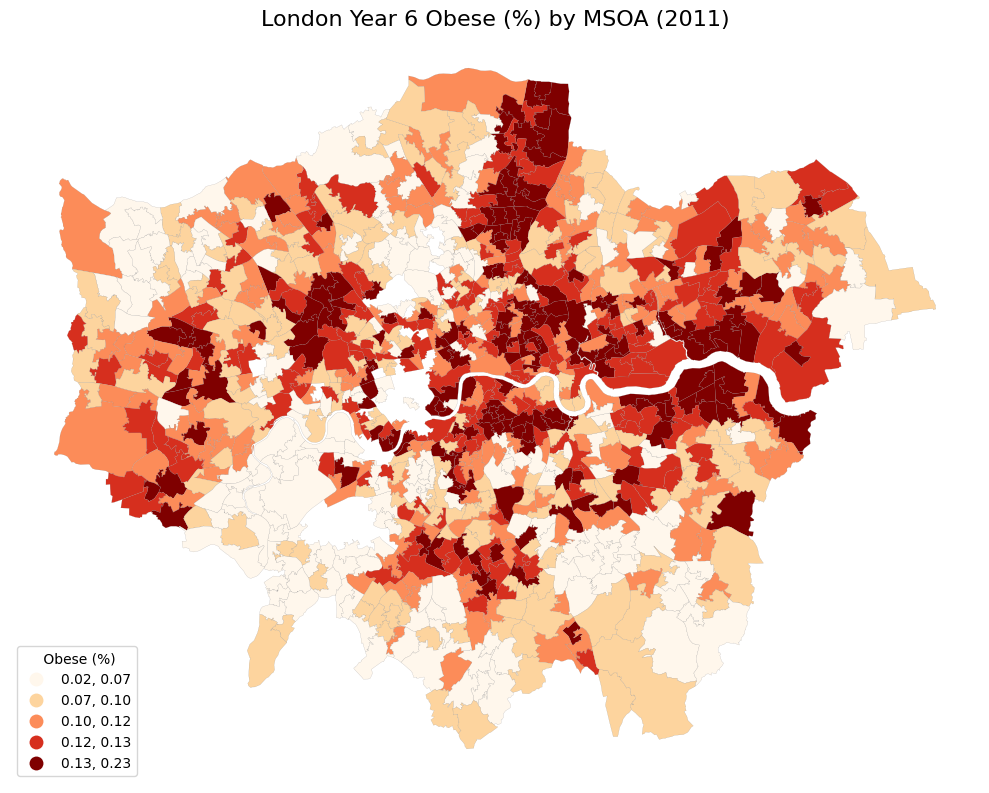

In [135]:
shp_path = r"cross_section_data\statistical-gis-boundaries-london\ESRI\MSOA_2011_London_gen_MHW.shp"
msoa_gdf = gpd.read_file(shp_path)

msoa_gdf = msoa_gdf.rename(columns={'MSOA11CD': 'Code'})

merged = msoa_gdf.merge(df_msoa, on='Code', how='left')


merged['% obese'] = pd.to_numeric(merged['% obese'], errors='coerce')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(
    column='% obese',
    cmap='OrRd',
    scheme='Quantiles',
    k=5,
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    legend_kwds={
        'title': ' Obese (%)',
        'loc': 'lower left',
        'fontsize': 10
    },
    ax=ax
)

ax.set_title("London Year 6 Obese (%) by MSOA (2011)", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

It can be seen that the MSOA level distribution of obesity incidence has a very obvious feature of more in the east and less in the west. W


 convert the MSOA data into a string to ensure the uniform format when matching the code later.


In [136]:
unemployment_path = r"cross_section_data\unemployment.csv"
income_path       = r"cross_section_data\income_MSOA.xls"
education_path    = r"cross_section_data\edu.csv"
density_path      = r"cross_section_data\population_density.csv"
ethnicity_path   = r"cross_section_data\ethnicity.csv"

# 2. load unemployment rate（CSV）
df_unemployment = pd.read_csv(
    unemployment_path,
    dtype={'MSOA code': str}   
)

# 3. load the income data（Excel，.xls）
df_income = pd.read_excel(
    income_path,
    sheet_name=0,
    dtype={'geography code': str}
)

# 4. load edu level data（CSV）
df_education = pd.read_csv(
    education_path,
    dtype={'geography code': str}
)

# 5. human density data（CSV）
df_density = pd.read_csv(
    density_path,
    dtype={'geography code': str}
)

# 6. load ethnicity data（CSV）
df_ethnicity = pd.read_csv(
    ethnicity_path,
    dtype={'geography code': str}
)

for name, df in [
    ("Unemployment", df_unemployment),
    ("Income", df_income),
    ("Education", df_education),
    ("Density", df_density),
    ("Ethnicity", df_ethnicity),
]:
    print(f"=== {name} DataFrame ===")
    print("Columns:", df.columns.tolist())
    display(df.head())

=== Unemployment DataFrame ===
Columns: ['date', 'geography', 'geography code', 'Rural Urban', 'Sex: All persons; Economic Activity: All usual residents aged 16 to 74; measures: Value', 'Sex: All persons; Economic Activity: Economically active; measures: Value', 'Sex: All persons; Economic Activity: Economically active: In employment; measures: Value', 'Sex: All persons; Economic Activity: Economically active: Employee: Part-time; measures: Value', 'Sex: All persons; Economic Activity: Economically active: Employee: Full-time; measures: Value', 'Sex: All persons; Economic Activity: Economically active: Self-employed; measures: Value', 'Sex: All persons; Economic Activity: Economically active: Unemployed; measures: Value', 'Sex: All persons; Economic Activity: Economically active: Full-time student; measures: Value', 'Sex: All persons; Economic Activity: Economically Inactive; measures: Value', 'Sex: All persons; Economic Activity: Economically inactive: Retired; measures: Value', 'Sex:

,date,geography,geography code,Rural Urban,Sex: All persons; Economic Activity: All usual residents aged 16 to 74; measures: Value,Sex: All persons; Economic Activity: Economically active; measures: Value,Sex: All persons; Economic Activity: Economically active: In employment; measures: Value,Sex: All persons; Economic Activity: Economically active: Employee: Part-time; measures: Value,Sex: All persons; Economic Activity: Economically active: Employee: Full-time; measures: Value,Sex: All persons; Economic Activity: Economically active: Self-employed; measures: Value,...,Sex: Females; Economic Activity: Economically Inactive; measures: Value,Sex: Females; Economic Activity: Economically inactive: Retired; measures: Value,Sex: Females; Economic Activity: Economically inactive: Student (including full-time students); measures: Value,Sex: Females; Economic Activity: Economically inactive: Looking after home or family; measures: Value,Sex: Females; Economic Activity: Economically inactive: Long-term sick or disabled; measures: Value,Sex: Females; Economic Activity: Economically inactive: Other; measures: Value,Sex: Females; Economic Activity: Unemployed: Age 16 to 24; measures: Value,Sex: Females; Economic Activity: Unemployed: Age 50 to 74; measures: Value,Sex: Females; Economic Activity: Unemployed: Never worked; measures: Value,Sex: Females; Economic Activity: Long-term unemployed; measures: Value
0,2011,Darlington 001,E02002559,Total,6521,4928,4609,927,2888,794,...,958,540,104,194,74,46,8,17,6,35
1,2011,Darlington 002,E02002560,Total,4462,3323,3006,731,1957,318,...,648,377,61,123,62,25,10,11,7,29
2,2011,Darlington 003,E02002561,Total,4342,3093,2816,706,1856,254,...,718,434,67,109,82,26,10,13,6,27
3,2011,Darlington 004,E02002562,Total,4473,3139,2672,726,1722,224,...,747,351,67,165,98,66,36,26,24,70
4,2011,Darlington 005,E02002563,Total,3912,2620,2366,640,1507,219,...,709,391,53,126,102,37,15,17,6,28


=== Income DataFrame ===
Columns: ['Contents', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9']


,Contents,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Net weekly household income (equivalised) afte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MSOA code,MSOA name,Local authority code,Local authority name,Region code,Region name,Net income after housing costs (£),Upper confidence limit (£),Lower confidence limit (£),Confidence interval (£)
4,E02004297,County Durham 001,E06000047,County Durham,E12000001,North East,450,510,390,120


=== Education DataFrame ===
Columns: ['date', 'geography', 'geography code', 'Rural Urban', 'Qualification: All categories: Highest level of qualification; measures: Value', 'Qualification: No qualifications; measures: Value', 'Qualification: Level 1 qualifications; measures: Value', 'Qualification: Level 2 qualifications; measures: Value', 'Qualification: Apprenticeship; measures: Value', 'Qualification: Level 3 qualifications; measures: Value', 'Qualification: Level 4 qualifications and above; measures: Value', 'Qualification: Other qualifications; measures: Value']


,date,geography,geography code,Rural Urban,Qualification: All categories: Highest level of qualification; measures: Value,Qualification: No qualifications; measures: Value,Qualification: Level 1 qualifications; measures: Value,Qualification: Level 2 qualifications; measures: Value,Qualification: Apprenticeship; measures: Value,Qualification: Level 3 qualifications; measures: Value,Qualification: Level 4 qualifications and above; measures: Value,Qualification: Other qualifications; measures: Value
0,2011,Darlington 001,E02002559,Total,7019,976,847,1114,345,939,2572,226
1,2011,Darlington 002,E02002560,Total,4826,1097,719,859,329,698,932,192
2,2011,Darlington 003,E02002561,Total,4789,1060,662,748,318,698,1107,196
3,2011,Darlington 004,E02002562,Total,4938,1511,726,816,245,688,710,242
4,2011,Darlington 005,E02002563,Total,4511,1457,615,670,282,517,766,204


=== Density DataFrame ===
Columns: ['date', 'geography', 'geography code', 'Rural Urban', 'Area/Population Density: All usual residents; measures: Value', 'Area/Population Density: Area Hectares; measures: Value', 'Area/Population Density: Density (number of persons per hectare); measures: Value']


,date,geography,geography code,Rural Urban,Area/Population Density: All usual residents; measures: Value,Area/Population Density: Area Hectares; measures: Value,Area/Population Density: Density (number of persons per hectare); measures: Value
0,2011,Darlington 001,E02002559,Total,8842,13247.01,0.7
1,2011,Darlington 002,E02002560,Total,5997,206.03,29.1
2,2011,Darlington 003,E02002561,Total,5741,146.95,39.1
3,2011,Darlington 004,E02002562,Total,6066,124.22,48.8
4,2011,Darlington 005,E02002563,Total,5463,156.19,35.0


=== Ethnicity DataFrame ===
Columns: ['date', 'geography', 'geography code', 'Rural Urban', 'Ethnic Group: All usual residents; measures: Value', 'Ethnic Group: White; measures: Value', 'Ethnic Group: White: English/Welsh/Scottish/Northern Irish/British; measures: Value', 'Ethnic Group: White: Irish; measures: Value', 'Ethnic Group: White: Gypsy or Irish Traveller; measures: Value', 'Ethnic Group: White: Other White; measures: Value', 'Ethnic Group: Mixed/multiple ethnic groups; measures: Value', 'Ethnic Group: Mixed/multiple ethnic groups: White and Black Caribbean; measures: Value', 'Ethnic Group: Mixed/multiple ethnic groups: White and Black African; measures: Value', 'Ethnic Group: Mixed/multiple ethnic groups: White and Asian; measures: Value', 'Ethnic Group: Mixed/multiple ethnic groups: Other Mixed; measures: Value', 'Ethnic Group: Asian/Asian British; measures: Value', 'Ethnic Group: Asian/Asian British: Indian; measures: Value', 'Ethnic Group: Asian/Asian British: Pakistani; m

,date,geography,geography code,Rural Urban,Ethnic Group: All usual residents; measures: Value,Ethnic Group: White; measures: Value,Ethnic Group: White: English/Welsh/Scottish/Northern Irish/British; measures: Value,Ethnic Group: White: Irish; measures: Value,Ethnic Group: White: Gypsy or Irish Traveller; measures: Value,Ethnic Group: White: Other White; measures: Value,...,Ethnic Group: Asian/Asian British: Bangladeshi; measures: Value,Ethnic Group: Asian/Asian British: Chinese; measures: Value,Ethnic Group: Asian/Asian British: Other Asian; measures: Value,Ethnic Group: Black/African/Caribbean/Black British; measures: Value,Ethnic Group: Black/African/Caribbean/Black British: African; measures: Value,Ethnic Group: Black/African/Caribbean/Black British: Caribbean; measures: Value,Ethnic Group: Black/African/Caribbean/Black British: Other Black; measures: Value,Ethnic Group: Other ethnic group; measures: Value,Ethnic Group: Other ethnic group: Arab; measures: Value,Ethnic Group: Other ethnic group: Any other ethnic group; measures: Value
0,2011,Darlington 001,E02002559,Total,8842,8614,8495,18,39,62,...,6,20,19,24,15,4,5,11,7,4
1,2011,Darlington 002,E02002560,Total,5997,5870,5804,13,10,43,...,7,2,12,15,3,11,1,6,0,6
2,2011,Darlington 003,E02002561,Total,5741,5604,5514,20,3,67,...,5,31,10,6,4,2,0,2,2,0
3,2011,Darlington 004,E02002562,Total,6066,5834,5655,4,9,166,...,13,13,23,25,17,6,2,8,3,5
4,2011,Darlington 005,E02002563,Total,5463,5332,5268,13,2,49,...,0,12,16,20,11,7,2,6,1,5


 use unemployed/ all annual residents age from 16 to 74 to get the rate 

In [137]:
num_col = 'Sex: All persons; Economic Activity: Economically active: Unemployed; measures: Value'
den_col = 'Sex: All persons; Economic Activity: All usual residents aged 16 to 74; measures: Value'


df_unemployment[num_col] = pd.to_numeric(df_unemployment[num_col], errors='coerce')
df_unemployment[den_col] = pd.to_numeric(df_unemployment[den_col], errors='coerce')


df_unemployment['unemployment_rate'] = df_unemployment[num_col] / df_unemployment[den_col]

df_unemployment_rate = df_unemployment[['geography code', 'unemployment_rate']].copy()
df_unemployment_rate.columns = ['MSOA Code', 'unemployment_rate']


df_unemployment_rate.to_csv('cross_section_data/unemployment_rate.csv', index=False)

df_unemployment_rate.head()

,MSOA Code,unemployment_rate
0,E02002559,0.025303
1,E02002560,0.040565
2,E02002561,0.039383
3,E02002562,0.074000
4,E02002563,0.042945


 use the data of income cutting the cost of houseliving and daily expenses 

In [138]:
df_income.columns = df_income.iloc[3]

df_income = df_income.drop(index=[0, 1, 2]).reset_index(drop=True)

print(df_income.columns.tolist())

['MSOA code', 'MSOA name', 'Local authority code', 'Local authority name', 'Region code', 'Region name', 'Net income after housing costs (£)', 'Upper confidence limit (£)', 'Lower confidence limit (£)', 'Confidence interval (£)']


In [139]:
df_net_income = df_income[[
    'MSOA code',
    'Net income after housing costs (£)'
]].copy()


df_net_income.columns = ['MSOA Code', 'net_income_after_housing']

df_net_income = df_net_income.drop(index=[0]).reset_index(drop=True)


df_net_income.to_csv(
    "cross_section_data/net_income_by_MSOA.csv",
    index=False
)


df_net_income.head()

,MSOA Code,net_income_after_housing
0,E02004297,450
1,E02004290,460
2,E02004298,470
3,E02004299,380
4,E02004291,370


 we use the **no qualification data/ all qualification** data to substitute the low edu level

In [140]:
print(df_education.columns.tolist())

['date', 'geography', 'geography code', 'Rural Urban', 'Qualification: All categories: Highest level of qualification; measures: Value', 'Qualification: No qualifications; measures: Value', 'Qualification: Level 1 qualifications; measures: Value', 'Qualification: Level 2 qualifications; measures: Value', 'Qualification: Apprenticeship; measures: Value', 'Qualification: Level 3 qualifications; measures: Value', 'Qualification: Level 4 qualifications and above; measures: Value', 'Qualification: Other qualifications; measures: Value']


In [141]:
df_education['no_qual_rate'] = df_education["Qualification: No qualifications; measures: Value"] / df_education["Qualification: All categories: Highest level of qualification; measures: Value"]


df_nqrate = df_education[['geography code', 'no_qual_rate']].copy()
df_nqrate.columns = ['MSOA Code', 'no_qual_rate']

df_nqrate.to_csv('cross_section_data/no_qualification_rate.csv', index=False)

from IPython.display import display
df_nqrate.head()

,MSOA Code,no_qual_rate
0,E02002559,0.139051
1,E02002560,0.227310
2,E02002561,0.221341
3,E02002562,0.305994
4,E02002563,0.322988


In [142]:
print(df_density.columns.tolist())

['date', 'geography', 'geography code', 'Rural Urban', 'Area/Population Density: All usual residents; measures: Value', 'Area/Population Density: Area Hectares; measures: Value', 'Area/Population Density: Density (number of persons per hectare); measures: Value']


In [143]:
df_density = df_density[['geography code', 'Area/Population Density: Density (number of persons per hectare); measures: Value']]


df_density.columns = [
    'MSOA Code',
    'Population density (people/hm\u00b2)'
]


df_density['Population density (people/hm\u00b2)'] = pd.to_numeric(
    df_density['Population density (people/hm\u00b2)'],
    errors='coerce'
)



df_density.to_csv(
    'cross_section_data/MSOA_population_density.csv',
    index=False
)


df_density.head()

,MSOA Code,Population density (people/hm²)
0,E02002559,0.7
1,E02002560,29.1
2,E02002561,39.1
3,E02002562,48.8
4,E02002563,35.0


 use the **NON-white people data/ all population** to get the rate of minority group.

In [144]:
cols = df_ethnicity.columns.tolist()
print("Columns:", cols)

Columns: ['date', 'geography', 'geography code', 'Rural Urban', 'Ethnic Group: All usual residents; measures: Value', 'Ethnic Group: White; measures: Value', 'Ethnic Group: White: English/Welsh/Scottish/Northern Irish/British; measures: Value', 'Ethnic Group: White: Irish; measures: Value', 'Ethnic Group: White: Gypsy or Irish Traveller; measures: Value', 'Ethnic Group: White: Other White; measures: Value', 'Ethnic Group: Mixed/multiple ethnic groups; measures: Value', 'Ethnic Group: Mixed/multiple ethnic groups: White and Black Caribbean; measures: Value', 'Ethnic Group: Mixed/multiple ethnic groups: White and Black African; measures: Value', 'Ethnic Group: Mixed/multiple ethnic groups: White and Asian; measures: Value', 'Ethnic Group: Mixed/multiple ethnic groups: Other Mixed; measures: Value', 'Ethnic Group: Asian/Asian British; measures: Value', 'Ethnic Group: Asian/Asian British: Indian; measures: Value', 'Ethnic Group: Asian/Asian British: Pakistani; measures: Value', 'Ethnic Gro

In [145]:
total_col = 'Ethnic Group: All usual residents; measures: Value'
white_col = 'Ethnic Group: White; measures: Value'


df_ethnicity[total_col] = pd.to_numeric(df_ethnicity[total_col], errors='coerce')
df_ethnicity[white_col] = pd.to_numeric(df_ethnicity[white_col], errors='coerce')


df_ethnicity['nonwhite_ratio'] = (df_ethnicity[total_col] - df_ethnicity[white_col]) / df_ethnicity[total_col]


df_unwhite = df_ethnicity[['geography code', 'nonwhite_ratio']].copy()
df_unwhite.columns = ['MSOA Code', 'nonwhite_ratio']


df_unwhite.to_csv('cross_section_data/nonwhite_ratio_by_MSOA.csv', index=False)

df_unwhite.head()

,MSOA Code,nonwhite_ratio
0,E02002559,0.025786
1,E02002560,0.021177
2,E02002561,0.023863
3,E02002562,0.038246
4,E02002563,0.023979


In [146]:
for name, df in [
    ("unemployment_rate", df_unemployment_rate),
    ("net_income", df_net_income),
    ("non_education", df_nqrate),
    ("human_density", df_density),
    ("non white_proportion", df_unwhite),
]:
    print(f"--- {name} column name ---")
    print(df.columns.tolist(), end="\n\n")

--- unemployment_rate column name ---
['MSOA Code', 'unemployment_rate']

--- net_income column name ---
['MSOA Code', 'net_income_after_housing']

--- non_education column name ---
['MSOA Code', 'no_qual_rate']

--- human_density column name ---
['MSOA Code', 'Population density (people/hm²)']

--- non white_proportion column name ---
['MSOA Code', 'nonwhite_ratio']



In [147]:
dfs = [df_unemployment_rate, df_net_income, df_nqrate, df_density, df_unwhite]



df_merged_5 = reduce(
    lambda left, right: pd.merge(left, right, on="MSOA Code", how="outer"),
    dfs
)


df_merged_5.shape
df_merged_5.head()

,MSOA Code,unemployment_rate,net_income_after_housing,no_qual_rate,Population density (people/hm²),nonwhite_ratio
0,E02000001,0.029650,810,0.067209,25.5,0.213695
1,E02000002,0.076835,410,0.323049,31.3,0.350111
2,E02000003,0.064205,490,0.228007,46.9,0.453858
3,E02000004,0.066697,500,0.301243,24.8,0.190230
4,E02000005,0.066408,430,0.289060,72.1,0.337304


In [148]:
df_merged_5.to_csv('cross_section_data/merged_data.csv', index=False)

In [149]:
missing_counts = df_merged_5.isnull().sum()


missing_pct = missing_counts / len(df_merged_5) * 100


missing_df = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_pct': missing_pct
})

print(missing_df)


                                 missing_count  missing_pct
MSOA Code                                    0     0.000000
unemployment_rate                            1     0.013885
net_income_after_housing                     1     0.013885
no_qual_rate                                 1     0.013885
Population density (people/hm²)              1     0.013885
nonwhite_ratio                               1     0.013885


### 3.4 Initial visualization

Before doing regression, we need to analyze the parameters involved in the regression to avoid the impact of inaccurate parameters on the experimental results.

In [150]:
gdf = msoa_gdf.merge(
    df_merged_5,
    how='left',
    left_on='Code',   
    right_on='MSOA Code'  
)

plot the data separately

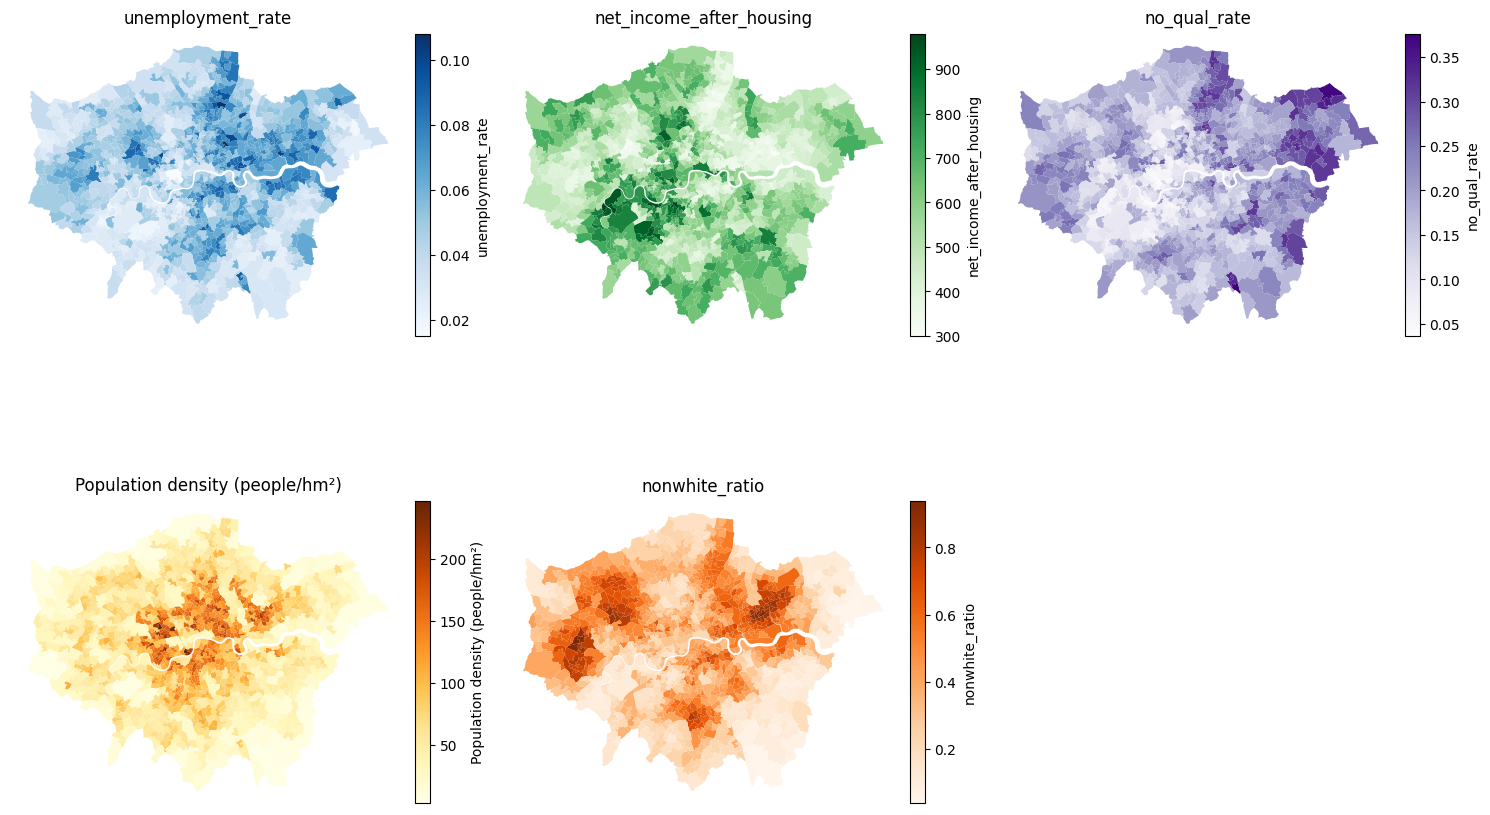

In [151]:
vars  = ['unemployment_rate','net_income_after_housing',
         'no_qual_rate','Population density (people/hm²)','nonwhite_ratio']
cmaps = ['Blues','Greens','Purples','YlOrBr','Oranges']

ncol = 3
nrow = (len(vars)+ncol-1)//ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(5*ncol, 5*nrow))

for ax, var, cmap in zip(axes.flatten(), vars, cmaps):
   
    gdf.plot(
        column=var,
        cmap=cmap,
        linewidth=0,
        edgecolor='none',
        legend=False,
        ax=ax
    )
    ax.set_title(var, fontsize=12)
    ax.set_axis_off()

    
    vmin, vmax = gdf[var].min(), gdf[var].max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  

    
    cbar = fig.colorbar(sm, ax=ax, fraction=0.036, pad=0.02)
    cbar.set_label(var, fontsize=10)


for ax in axes.flatten()[len(vars):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

| Variable                            | Type         | Description                                                             |Notes   |
|-------------------------------------|--------------|-------------------------------------------------------------------------|---|
| Burglary crime rate                 | Numeric      | The burglary rate of MSOAs. Used as dependent variables in regression.  |   |
| Temperature                         | Numeric      | The daytime temperature                                                 |   |
| Indicator of Inner or Outer London  | Categorical  | Whether the MSOA is in Inner London.                                    |   |
| ......  | ......  | ......                                    |   |

## 4. Methodology

[[ go back to the top ]](#Table-of-contents)

![流程图](https://raw.githubusercontent.com/loveHeath0105/Data_Science/main/flow_chart.png)

We have known the basic distribution of the 5 factors, but we need to know if they are valid and reliable, so we need to know if they align with the normal distribution, and also check if they have some self correlations. Because basically the OLS regression requires us to do so.

### 4.1 KDE combing with the histogram

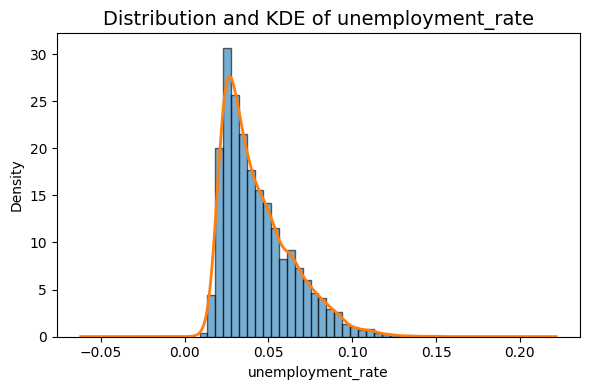

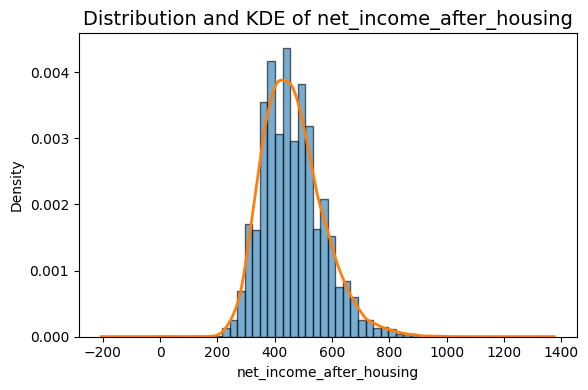

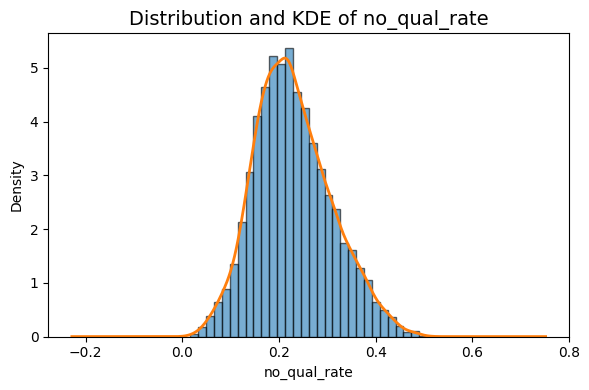

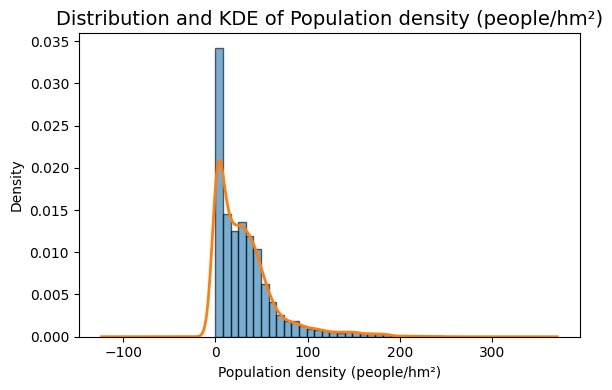

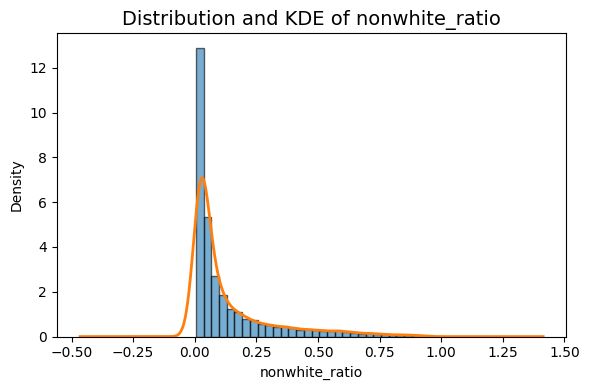

In [152]:
vars = [
    'unemployment_rate',
    'net_income_after_housing',
    'no_qual_rate',
    'Population density (people/hm²)',
    'nonwhite_ratio',
    
]


for v in vars:
    data = df_merged_5[v].dropna()
    plt.figure(figsize=(6, 4))
    
    plt.hist(data, bins=30, density=True, alpha=0.6, edgecolor='black')
    
    data.plot(kind='kde', linewidth=2)
    plt.title(f'Distribution and KDE of {v}', fontsize=14)
    plt.xlabel(v)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

Although we see skewed distributions in two of the parameters, which may not be the result we want, we can continue to test the data because the KDE is relatively smooth and does not show a particularly obvious skewed.

### 4.2 Correlation Matrix 

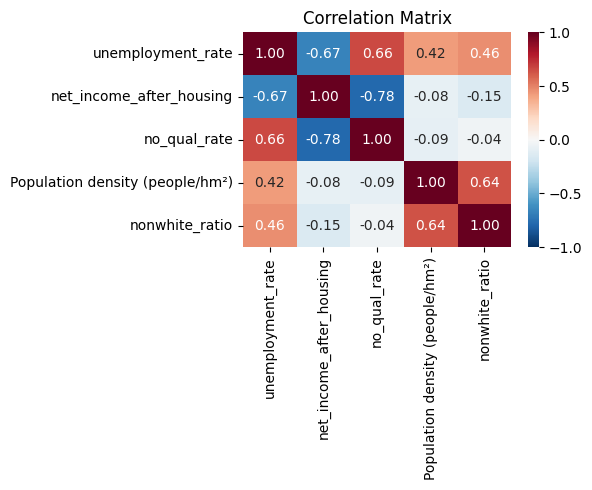

In [153]:
corr = df_merged_5[vars].corr()


plt.figure(figsize=(6, 5))
sns.heatmap(
    corr,
    annot=True,        
    fmt='.2f',         
    cmap='RdBu_r',     
    vmin=-1, vmax=1    
)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

From the correlation matrix, this special situation indicates that they do have some relationship but it is at least not linear. Since our research is about the influence of each parameter on obesity, we cannot discard these existing parameters to evaluate the model, nor can we combine them into a new parameter. So here we use the random forest method for regression.

It can be found that most of the |correlation| is over 0.4, which means they have a very strong correlation with each other, SO WE can't use them all by OLS.

### 4.3 Random Forest regression

In [154]:
df_feats = pd.read_csv(r"cross_section_data\merged_data.csv", dtype={'MSOA Code': str})
feats_codes = set(df_feats['MSOA Code'])


df_obese = pd.read_csv(r"cross_section_data\obese_MSOA_data.csv", dtype={'Code': str})
obese_codes = set(df_obese['Code'])

print(f"feats_codes: {len(feats_codes)}")
print(f" obese_codes: {len(obese_codes)}")
print(f"feats_codes & obese_codes: {len(feats_codes & obese_codes)}")

feats_codes: 7202
 obese_codes: 983
feats_codes & obese_codes: 983


In [155]:
df_merged_final = pd.merge(
    df_feats,
    df_obese[['Code', '% obese']],  
    left_on='MSOA Code',
    right_on='Code',

    how='inner'
)

In [156]:
features = [
    'unemployment_rate',
    'net_income_after_housing',
    'no_qual_rate',
    'Population density (people/hm²)',
    'nonwhite_ratio'
]
target = '% obese'


df = df_merged_final.copy()


for col in features + [target]:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df = df.dropna(subset=features + [target]).reset_index(drop=True)


X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

print("training sample：", X_train.shape[0])
print("testing sample：",  X_test.shape[0])

training sample： 664
testing sample： 285


Build the model and training

In [157]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    oob_score=True,
    min_samples_leaf=5,
    n_jobs=-1
)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
print("Test RMSE:", root_mean_squared_error(y_test, y_pred))
print("Test R²  :", r2_score(y_test, y_pred))
print("OOB R²   :", rf.oob_score_)


importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature importances:\n", importances)

Test RMSE: 0.0243060942920334
Test R²  : 0.4635470744235337
OOB R²   : 0.48122923197866163

Feature importances:
 net_income_after_housing           0.523748
unemployment_rate                  0.238560
Population density (people/hm²)    0.083107
nonwhite_ratio                     0.082270
no_qual_rate                       0.072315
dtype: float64


In [158]:
params = rf.get_params()
print(params)


print(" n_estimators  =", rf.n_estimators)
print(" max_depth      =", rf.max_depth)
print(" max_features =", rf.max_features)
print(" min_samples_leaf =", rf.min_samples_leaf)
print(" min_samples_split =", rf.min_samples_split)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}
 n_estimators  = 200
 max_depth      = None
 max_features = 1.0
 min_samples_leaf = 5
 min_samples_split = 2


forcast the data and get the importance of each factor

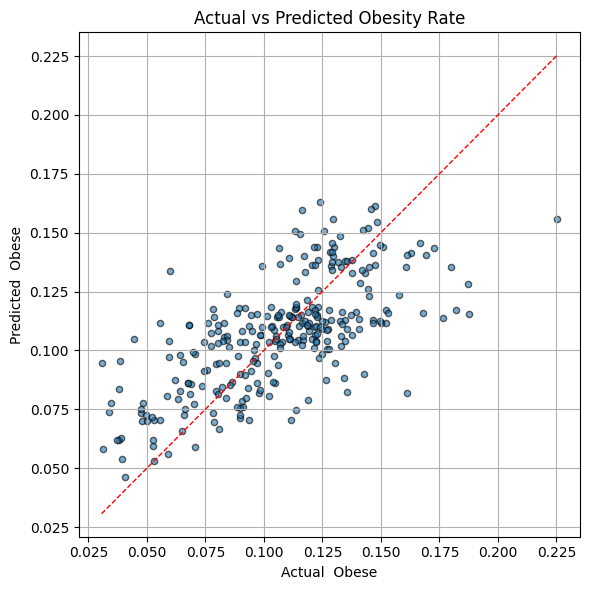

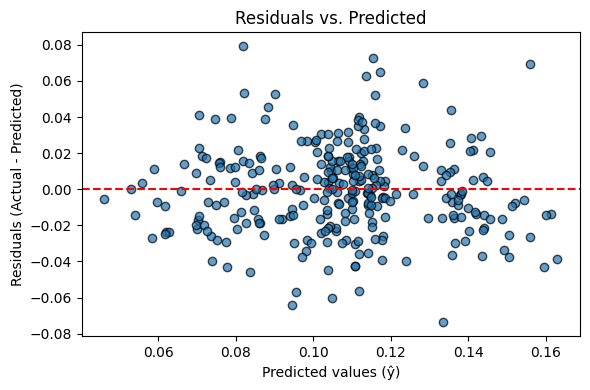

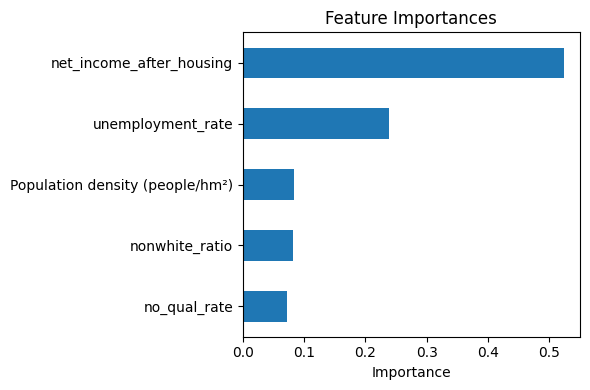

In [159]:
y_pred = rf.predict(X_test)
residuals = y_test - y_pred


plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, s=20, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1)
plt.xlabel('Actual  Obese')
plt.ylabel('Predicted  Obese')
plt.title('Actual vs Predicted Obesity Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))

plt.scatter(y_pred, residuals, alpha=0.7, edgecolor='black')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values (ŷ)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs. Predicted')
plt.tight_layout()
plt.show()

importances = pd.Series(rf.feature_importances_, index=X_test.columns).sort_values(ascending=True)
plt.figure(figsize=(6, 4))
importances.plot(kind='barh')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

### 4.4 Grid Search to Optimize the hyperparameters

In [160]:
param_grid = {
    'n_estimators':      [100, 200, 500],
    'max_depth':         [None, 5, 10, 20],
    'max_features':      ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 5]
}


base_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=base_rf,
    param_grid=param_grid,
    cv=5,                 
    scoring='r2',          
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train, y_train)


print("the best params：", grid_search.best_params_)
print("the best CV R²：", grid_search.best_score_)


best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print(f"Test RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")
print(f"Test R²  : {r2_score(y_test, y_pred):.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
the best params： {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
the best CV R²： 0.503673121142131
Test RMSE: 0.0241
Test R²  : 0.4746


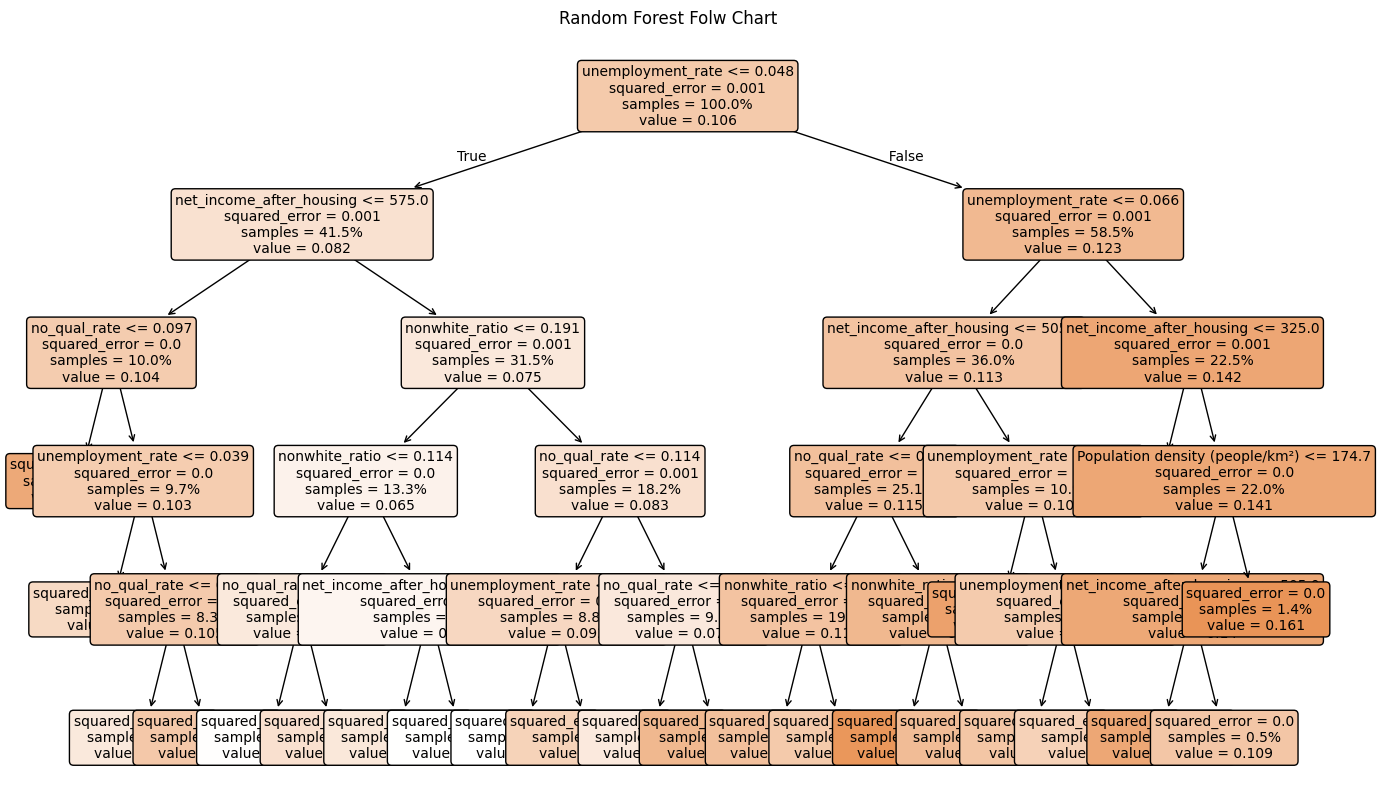

In [161]:
i = 0  
single_tree = best_rf.estimators_[i]


plt.figure(figsize=(16, 10))
plot_tree(
    single_tree,
    feature_names=[
        'unemployment_rate',
        'net_income_after_housing',
        'no_qual_rate',
        'Population density (people/km²)',
        'nonwhite_ratio'
    ],
    filled=True,       
    rounded=True,      
    impurity=True,     
    proportion=True,   
    fontsize=10
)
plt.title(f"Random Forest Folw Chart")
plt.show()

Here we have optimized the hyperparameters to make it as reasonably distributed as possible. Here we can see that the unemployment rate, which was previously the main source, is almost balanced with the income source.

## 5. Results and discussion

[[ go back to the top ]](#Table-of-contents)

### 5.1 Random Forest regression Output

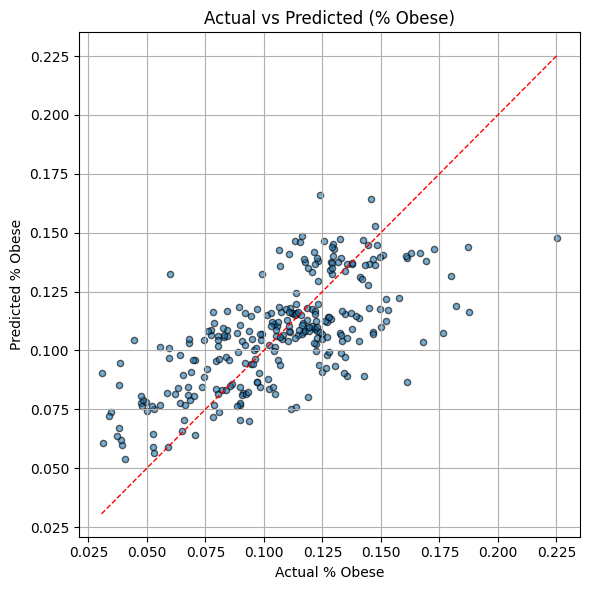

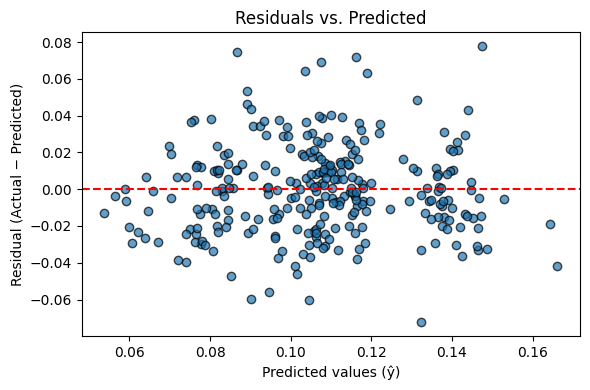

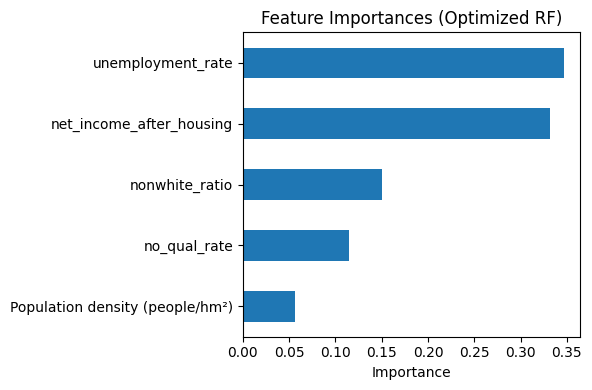

In [162]:
y_pred   = best_rf.predict(X_test)
residual = y_test - y_pred


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=20, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=1)
plt.xlabel('Actual % Obese')
plt.ylabel('Predicted % Obese')
plt.title('Actual vs Predicted (% Obese)')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residual, alpha=0.7, edgecolor='black')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values (ŷ)')
plt.ylabel('Residual (Actual − Predicted)')
plt.title('Residuals vs. Predicted')
plt.tight_layout()
plt.show()


importances = pd.Series(
    best_rf.feature_importances_,
    index=X_test.columns
).sort_values(ascending=True)

plt.figure(figsize=(6,4))
importances.plot(kind='barh')
plt.xlabel('Importance')
plt.title('Feature Importances (Optimized RF)')
plt.tight_layout()
plt.show()

### 5.2 Residuals analysis

####  Moran's I

Now we start to discuss the spatial autocorrelation of obesity prevalence. First, we use Moran's I to test whether it exists.

In [163]:
df_merged_final['MSOA Code'] = df_merged_final['MSOA Code'].astype(str)
geomerged_final = msoa_gdf.merge(
    df_merged_final,
    left_on='Code',
    right_on='MSOA Code',
    how='left'    
)

In [164]:
best_rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,
    max_features='log2',
    min_samples_split=10,
    min_samples_leaf=1,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=5, max_features='log2', min_samples_split=10,
                      n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=42)

In [165]:
gdf_test = geomerged_final.loc[X_test.index].copy()
gdf_test['residual']=residual
coords = np.array(list(gdf_test.geometry.centroid.apply(lambda p: (p.x,p.y))))
w_knn = KNN.from_array(coords, k=5)  
w_knn.transform = 'r'

mi_knn = esda.Moran(gdf_test['residual'], w_knn)
print(mi_knn.I, mi_knn.p_sim)

0.09139098288489612 0.008


The p-value based on the permutation test is 0.005, indicating that there is significant autocorrelation in the space

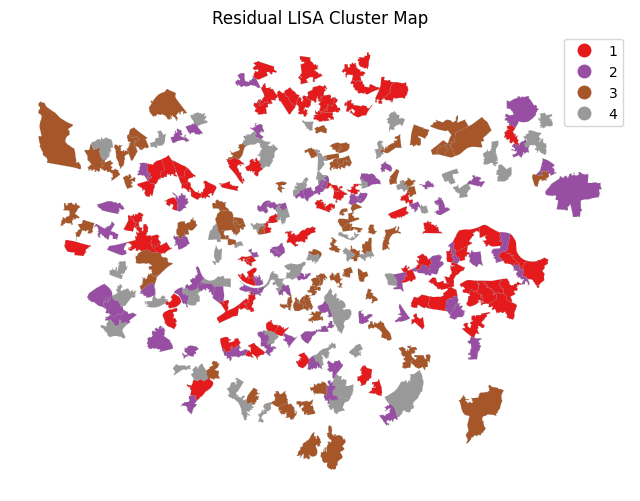

In [166]:
lm = Moran_Local(gdf_test['residual'], w_knn)

  
#    1 = HH, 2 = LH, 3 = LL, 4 = HL
labels = lm.q


fig, ax = plt.subplots(1,1, figsize=(8,8))
gdf_test.assign(lisa_cluster=labels).plot(
    column='lisa_cluster',
    categorical=True,
    cmap='Set1',
    linewidth=0.1,
    edgecolor='grey',
    legend=True,
    ax=ax
)
ax.set_title("Residual LISA Cluster Map")
ax.axis('off')
plt.show()

High–High (HH) areas (red) have positive residuals and are surrounded by neighbors with positive residuals, indicating systematic underestimation of obesity rates.The rest of the same：purple is Low-High(LH), brown is Low-Low(LL), and grew is High-Low(HL). Purple and brown areas are significantly affected by spatial autocorrelation, and they occupy a large amount of MSOA

#### SAR Model

Fitting a spatial lag model using maximum likelihood (ML): not only is it related to a set of explanatory variables X, but there may also be a "spatial contagion" effect - that is, whether the residuals in a certain area are affected by the residuals in its neighboring areas

In [167]:
y = gdf_test['residual'].values.reshape(-1, 1)


X = np.hstack([
    np.ones((len(y), 1)),            
    gdf_test[features].values          
])


name_x = ['constant'] + features


sar = ML_Lag(
    y, 
    X, 
    w_knn, 
    name_y='residual', 
    name_x=name_x, 
    name_w='knn5'
)


print(sar.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :        knn5
Dependent Variable  :    residual                Number of Observations:         285
Mean dependent var  :     -0.0004                Number of Variables   :           7
S.D. dependent var  :      0.0241                Degrees of Freedom    :         278
Pseudo R-squared    :      0.0529
Spatial Pseudo R-squared:  0.0291
Log likelihood      :    664.5290
Sigma-square ML     :      0.0005                Akaike info criterion :   -1315.058
S.E of regression   :      0.0234                Schwarz criterion     :   -1289.491

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

Here we can find that since the population density has |p-value|=0.04<0.05, we reject the null hypothesis which is that the spatial autocorrelation of population density has no effect on residuals and believe that its significant effect on residuals is related to spatial factors.

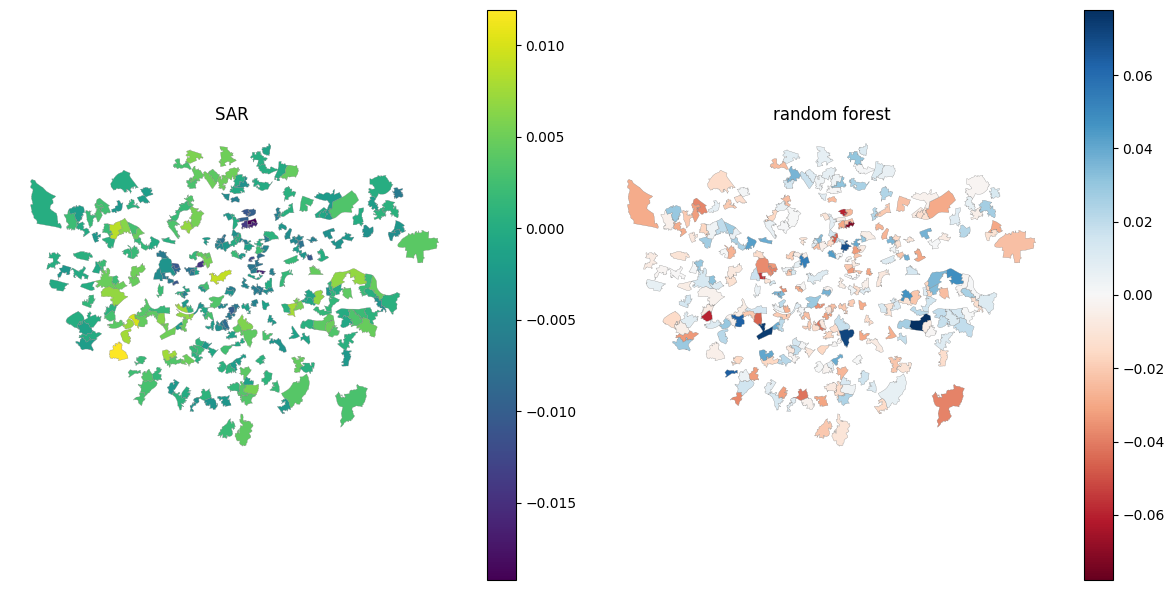

In [168]:
gdf_test['sar_fitted'] = sar.predy.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

gdf_test.plot(
    column='sar_fitted',
    cmap='viridis',
    legend=True,
    ax=axes[0],
    edgecolor='grey',
    linewidth=0.2
)
axes[0].set_title("SAR ")
axes[0].axis('off')

gdf_test.plot(
    column='residual',
    cmap='RdBu',
    legend=True,
    ax=axes[1],
    edgecolor='grey',
    linewidth=0.2,
    vmin=-gdf_test['residual'].abs().max(),
    vmax= gdf_test['residual'].abs().max()
)
axes[1].set_title("random forest")
axes[1].axis('off')

plt.tight_layout()
plt.show()

The left picture is the residual graph of SAR and the right picture is the residual graph of random forest. We can see that after eliminating the influence of spatial autocorrelation, our residuals have obviously improved a lot.

## 6. Conclusion

[[ go back to the top ]](#Table-of-contents)

**1. To what extent do these 5 factors explain the variation in obesity prevalence across London?**

If spatial characteristics are not considered, the results of random forest show that unemployment rate and income level have the greatest impact on the prevalence of obesity, and the rest are smaller, with the smallest being population density.

**2. Are there spatial correlations among factors affecting obesity?**

There is significant spatial autocorrelation in obesity prevalence, so the regression of many MSOA regions is affected, resulting in inaccurate

**3. If obesity prevalence is spatially autocorrelated, to what extent is it correlated? What parameters are not affected?**

For population density, it is significantly affected by spatial autocorrelation, while other parameters are still applicable to traditional regression models for obesity models.

In conclusion, we should pay more attention to the impact of economic status on obesity, while traditional factors such as education level and race may have little impact; therefore, we encourage the government to provide appropriate financial assistance to MSOA, where obesity is common.


In [ ]:
elapsed = time.time() - _nb_start_time
print(f"Notebook total run time: {elapsed:.1f} seconds")


Notebook total run time: 43.9 seconds


## 7. References

[[ go back to the top ]](#Table-of-contents)

Agyemang, C., Bhopal, R. & Bruijnzeels, M., 2011. Ethnic inequalities in obesity among children and adults in the UK: a systematic review of the literature. Obesity Reviews, 12(5), pp.e26–e36. DOI: 10.1111/j.1467-789X.2010.00829.x.

Fraser, L.K., Clarke, G.P., Cade, J.E. & Edwards, K.L., (2012). Fast food and obesity: a spatial analysis in a large United Kingdom population of children aged 13-15. American Journal of Preventive Medicine, 42(5), pp.77–85. DOI: 10.1016/j.amepre.2012.02.007.

Lockyer, S. & Spiro, A., (2019). Socio-economic inequalities in childhood obesity: Can community level interventions help to reduce the gap? Nutrition Bulletin, 44(4), pp.381–393. DOI: 10.1111/nbu.12410.

Qin, W., Wang, L., Xu, L., Sun, L., Li, J., Zhang, J. & Shao, H., (2019). An exploratory spatial analysis of overweight and obesity among children and adolescents in Shandong, China. BMJ Open, 9(8), e028152. DOI: 10.1136/bmjopen-2018-028152.

Sun, Y., Hu, X., Huang, Y., & Chan, T. O. (2020). Spatial patterns of childhood obesity prevalence in relation to socioeconomic factors across England. ISPRS International Journal of Geo-Information, 9(10), 14. DOI: https://doi.org/10.3390/ijgi9100599

Wang, Y. & Lim, H., (2012). Socioeconomic status and other factors associated with childhood obesity. Pediatric Clinics of North America, 59(2), pp.514-521. DOI: 10.1016/j.pcl.2011.12.009.

